In [3]:
#Propensity Modeling for an E-Commerce Company
#Our Client is an early-stage e-commerce company selling various products from daily essentials (such as Dairy & vegetables) 
#to high-end electronics and home appliances. It is a #one-year-old company and they are witnessing many people coming to their
#platform and searching for products but only a few end up purchasing.
#
#To increase the number of purchases, the business is planning to send discounts or coupons to users to motivate them to buy.
# But since it is an early-stage startup, they have only #limited funds for this discount campaign. 
#So, they have reached out to us seeking our help in building a model that would predict the purchase probability of each user in buying a #product. 
#We will be making use of propensity modeling for this.

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import calendar
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import missingno as mano
from datetime import timedelta
warnings.filterwarnings('ignore')


In [25]:
cust = pd.read_csv('C:/Users/Omar Hamzic/Documents/Project_1_Customer_Propensity_Model/data/data/final_customer_data.csv')
#saw that there were two unnamed columns that we are going to remove
cust= cust.drop(columns = ['Unnamed: 9', 'Unnamed: 10'])
cust = cust[cust['User_id'].notna()]
cust['DateTime'] = pd.to_datetime(cust['DateTime']) #convert to datetime format an not string
cust.info()
cust.head(5)
print(cust.shape)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   User_id      2090 non-null   float64       
 1   Session_id   2090 non-null   object        
 2   DateTime     2090 non-null   datetime64[ns]
 3   Category     2090 non-null   object        
 4   SubCategory  2090 non-null   object        
 5   Action       2090 non-null   object        
 6   Quantity     201 non-null    float64       
 7   Rate         201 non-null    float64       
 8   Total Price  201 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 163.3+ KB
(2090, 9)


## Univariate Analysis

Univariate analysis is a fundamental step in data analysis, providing essential insights into individual variables. It helps us understand the distribution, quality, and characteristics of each variable, aids in data cleaning and visualization, guides variable selection, and serves as a basis for exploratory data analysis (EDA). Through summary statistics and visualizations, univariate analysis informs subsequent data transformation and hypothesis generation, making it an integral part of the data analysis process.


In [4]:
#time range of data

print("First Date: " + str(cust.DateTime.min()))
print("Latest Date: " + str(cust.DateTime.max()))
print("Range: " + str(cust.DateTime.max()- cust.DateTime.min()))


First Date: 2019-01-01 11:00:00
Latest Date: 2019-12-22 17:52:00
Range: 355 days 06:52:00


Total Unique Categories: 105


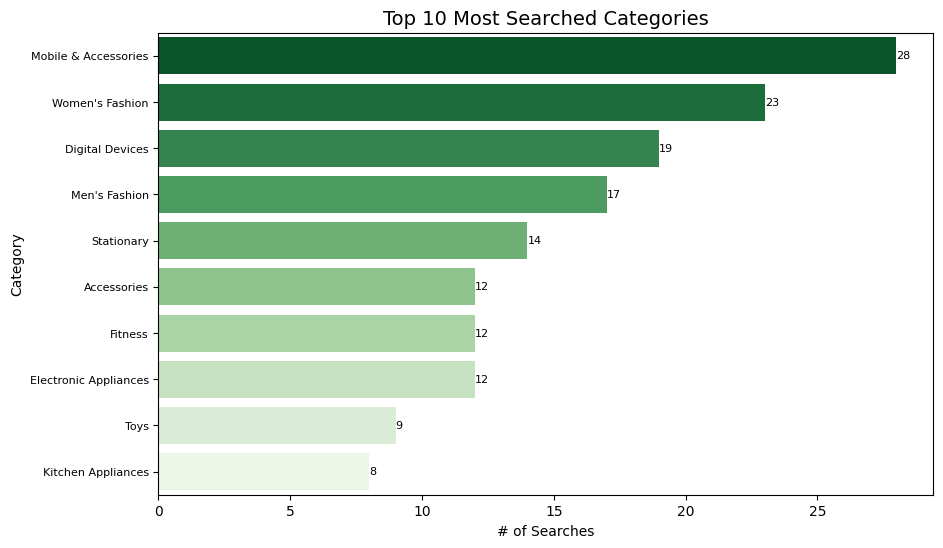

In [5]:
#Distribution Of Categories Based on Search

cust_search = cust[cust['Action'] == 'search']
temp_cust = cust_search.groupby('Category')['Session_id'].count().sort_values(ascending =False).reset_index()[:10]
#temp_cust
plt.figure(figsize = (10,6))
temp_plot = sns.barplot(x=temp_cust.Session_id, y=temp_cust.Category, orient='h', palette='Greens_r')
plt.title('Top 10 Most Searched Categories', size=14)

def format_with_commas(x, pos):
    return '{:,}'.format(int(x))

formatter = ticker.FuncFormatter(format_with_commas)
temp_plot.xaxis.set_major_formatter(formatter)
plt.xticks( ha='center', size=10,  )
plt.yticks(size=8)
plt.xlabel('# of Searches')
plt.ylabel('Category')

def format_with_commas(x, pos):
    return '{:,}'.format(int(x))
for i in temp_plot.containers:
    temp_plot.bar_label(i, label_type='edge',fmt= formatter, size = 8,
                                   )
print("Total Unique Categories: " + str(cust.Category.nunique()))
plt.show()




Total Unique Sub-Categories: 364


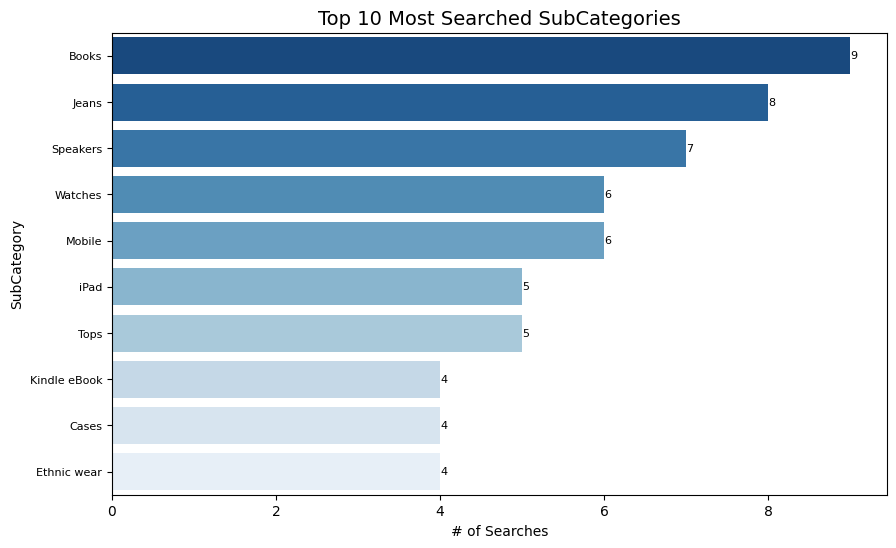

In [6]:
#Distribution of SubCategory

cust_search = cust[cust['Action'] == 'search']
temp_cust = cust_search.groupby('SubCategory')['Session_id'].count().sort_values(ascending =False).reset_index()[:10]
#temp_cust
plt.figure(figsize = (10,6))
temp_plot = sns.barplot(x=temp_cust.Session_id, y=temp_cust.SubCategory, orient='h', palette='Blues_r')
plt.title('Top 10 Most Searched SubCategories', size=14)

def format_with_commas(x, pos):
    return '{:,}'.format(int(x))

formatter = ticker.FuncFormatter(format_with_commas)
temp_plot.xaxis.set_major_formatter(formatter)
plt.xticks( ha='center', size=10,  )
plt.yticks(size=8)
plt.xlabel('# of Searches')
plt.ylabel('SubCategory')

def format_with_commas(x, pos):
    return '{:,}'.format(int(x))
for i in temp_plot.containers:
    temp_plot.bar_label(i, label_type='edge',fmt= formatter, size = 8,
                                   )
print("Total Unique Sub-Categories: " + str(cust.SubCategory.nunique()))
plt.show()

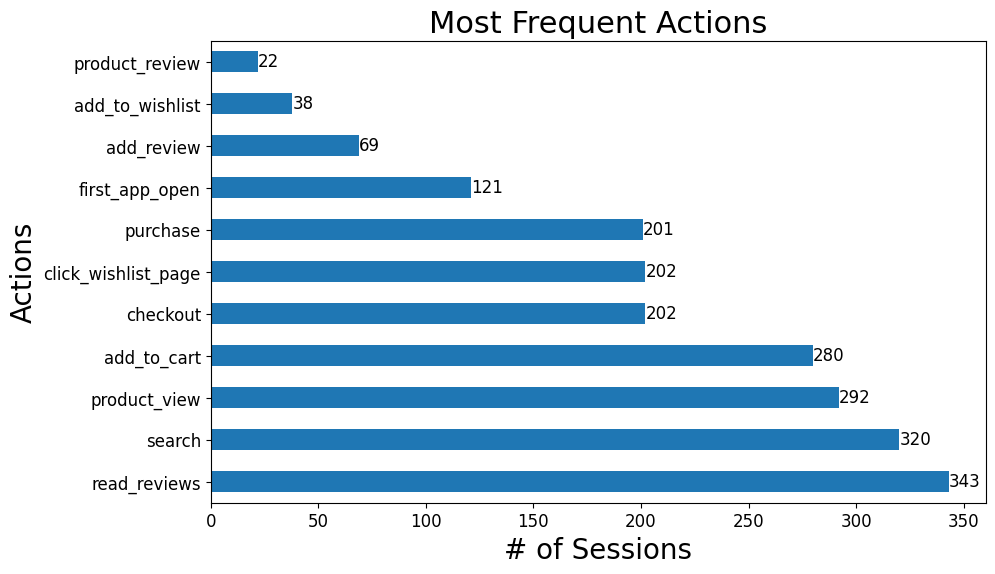

In [7]:
#display(cust.Action.value_counts())
cust['Action'] = cust['Action'].apply(lambda x: 'read_reviews' if x in ('read_review') else ('add_to_wishlist' if x in ('add_to_wishist') else x))

temp_act = cust.groupby('Action')["Session_id"].count().sort_values(ascending =False)#.reset_index()[:10]

plt.figure(figsize=(10,6))

ax = temp_act.plot.barh()
plt.title('Most Frequent Actions', size=22)
plt.xticks( ha='center', size=12)
plt.yticks(size=12)
plt.xlabel('# of Sessions', size =20)
plt.ylabel('Actions', size = 20)

for index, value in enumerate(temp_act):
    rounded_value = round(value, 1)
    plt.text(value, index, str(rounded_value), va='center', size=12)

plt.show()

Summary stats of Quantity:


,Quantity
count,201.000000
mean,2.965174
std,7.161968
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,100.000000


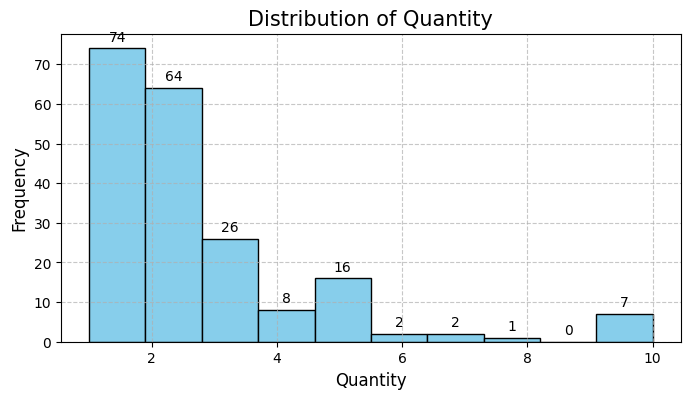

In [8]:
# Distribution of Quantity

# Print summary statistics
print("Summary stats of Quantity:")
display(cust[['Quantity']].describe())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the histogram
n, bins, patches = plt.hist(cust[cust['Quantity'] < 100]['Quantity'], bins=10, density=False, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Quantity", size=12)
plt.ylabel("Frequency", size=12)
plt.title("Distribution of Quantity", size=15)

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate each bar with its count
for count, rect in zip(n, patches):
    height = rect.get_height()
    ax.annotate(f'{int(count)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Show the plot
plt.show()




Summary stats of Rate:


,Rate
count,201.000000
mean,7133.283582
std,14778.150668
min,10.000000
25%,500.000000
50%,1200.000000
75%,6000.000000
max,90000.000000


Total records less than or equal to 75% cut: 154
Total records greater than 75% cut: 47


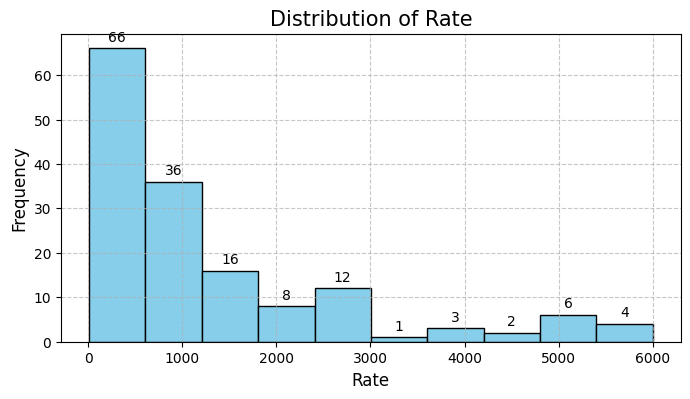

In [9]:
# Distribution of Rate

# Print summary statistics
print("Summary stats of Rate:")
display(cust[['Rate']].describe())

# Calculate the number of records less than or equal to 75% cut and greater than 75% cut
rate_cutoff = 6000
num_records_below_cutoff = cust[cust['Rate'] <= rate_cutoff].shape[0]
num_records_above_cutoff = cust[cust['Rate'] > rate_cutoff].shape[0]
print("Total records less than or equal to 75% cut: " + str(num_records_below_cutoff))
print("Total records greater than 75% cut: " + str(num_records_above_cutoff))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the histogram
n, bins, patches = plt.hist(cust[cust['Rate'] <= rate_cutoff]['Rate'], density=False, bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Rate", size=12)
plt.ylabel("Frequency", size=12)
plt.title("Distribution of Rate", size=15)

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate each bar with its count
for count, rect in zip(n, patches):
    height = rect.get_height()
    ax.annotate(f'{int(count)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Show the plot
plt.show()


Summary stats of Total Price:


,Total Price
count,201.000000
mean,9455.373134
std,18213.695424
min,150.000000
25%,1000.000000
50%,2500.000000
75%,8000.000000
max,160000.000000


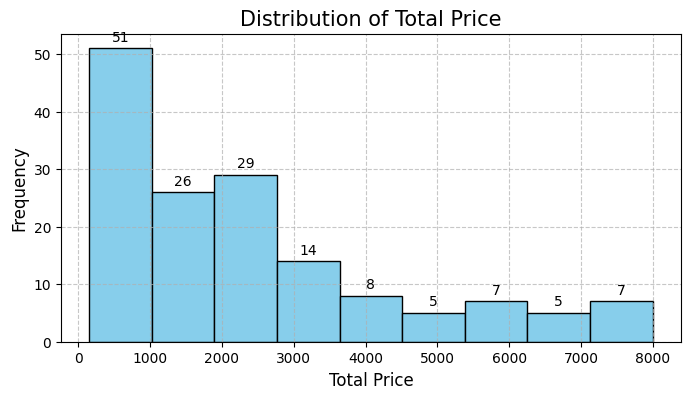

In [10]:
# Distribution of Total Price

# Function to create and annotate histograms
def create_annotated_histogram(data, column_name, cutoff, bins=9):
    # Print summary statistics
    print(f"Summary stats of {column_name}:")
    display(data[[column_name]].describe())

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 4))

    # Plot the histogram
    n, bins, patches = plt.hist(data[data[column_name] <= cutoff][column_name], density=False, bins=bins, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.xlabel(column_name, size=12)
    plt.ylabel("Frequency", size=12)
    plt.title(f"Distribution of {column_name}", size=15)

    # Show grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotate each bar with its count
    for count, rect in zip(n, patches):
        height = rect.get_height()
        ax.annotate(f'{int(count)}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

    # Show the plot
    plt.show()

# Call the function for the 'Total Price' column
total_price_cutoff = 8000
create_annotated_histogram(cust, 'Total Price', total_price_cutoff)


Total Unique Categories: 105


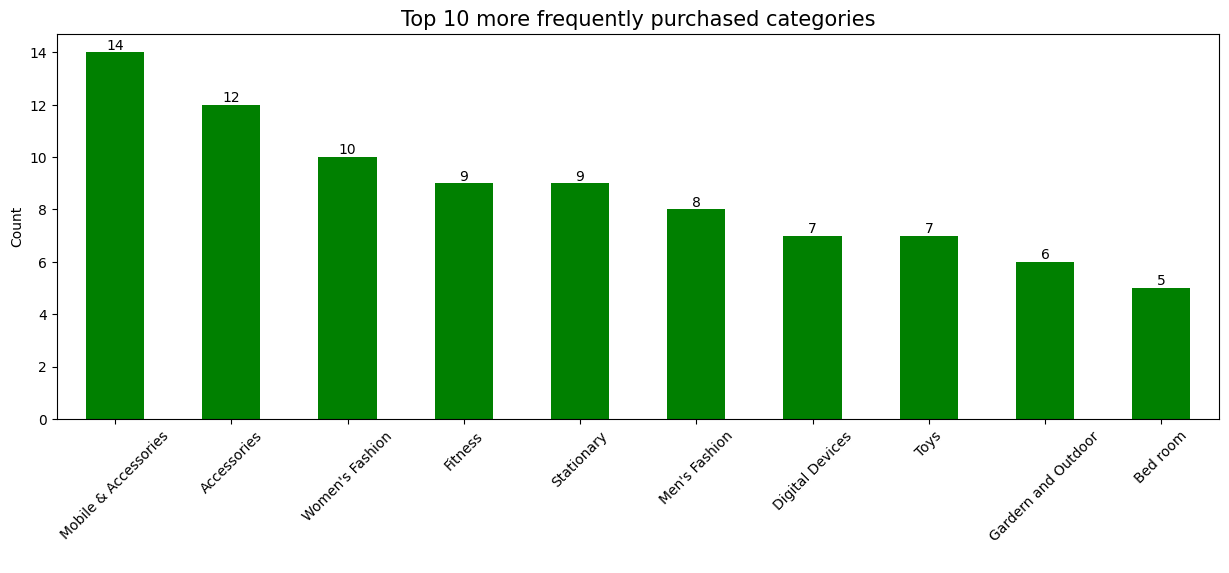

Total Unique SubCategories: 364


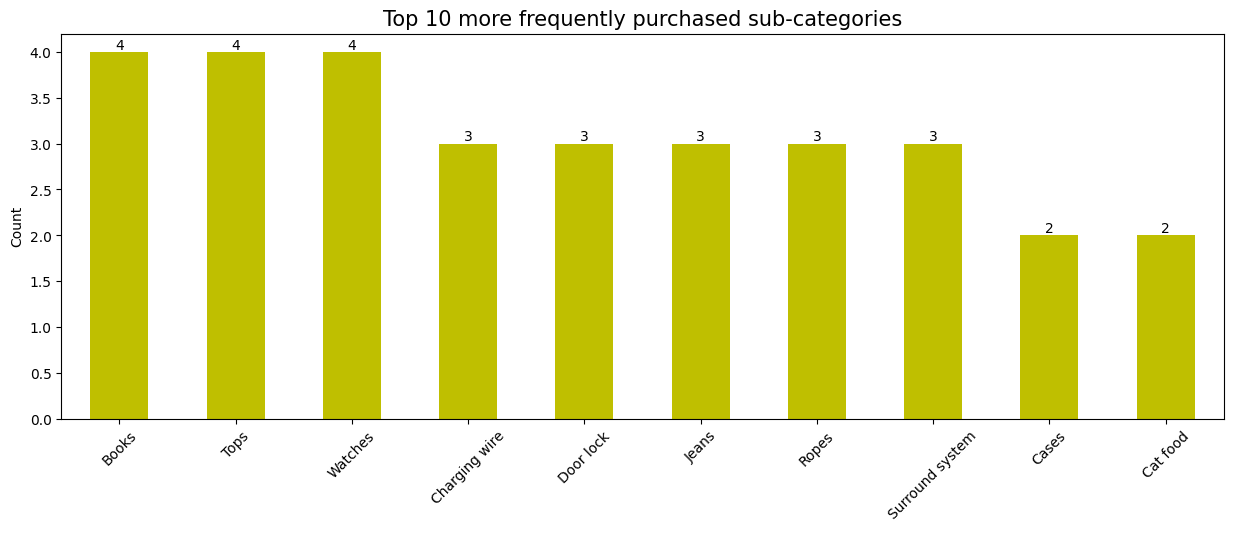

In [15]:
# Function to create and display top N category/subcategory plots with annotations
def plot_top_n(data, column, n, title):
    top_n = data[data['Action'] == 'purchase'].groupby(column)['User_id'].count().nlargest(n)
    
    plt.figure(figsize=(15, 5))
    ax = top_n.plot(kind='bar', color='g' if column == 'Category' else 'y')
    plt.title(title, size=15)
    plt.xticks(rotation=45)
    plt.xlabel(" ")
    plt.ylabel("Count")
    
    # Add annotations
    for i, count in enumerate(top_n):
        plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')

    plt.show()

# Top 10 purchased Category
print("Total Unique Categories:", cust['Category'].nunique())
plot_top_n(cust, 'Category', 10, "Top 10 more frequently purchased categories")

# Top 10 purchased SubCategory
print("Total Unique SubCategories:", cust['SubCategory'].nunique())
plot_top_n(cust, 'SubCategory', 10, "Top 10 more frequently purchased sub-categories")


## Multivariate Analysis:

Multivariate analysis is a crucial phase in data analysis where relationships and interactions among multiple variables are examined. It enables the exploration of complex data patterns, dependencies, and correlations between variables. Through techniques like scatterplots, correlation matrices, and multivariate statistical tests, multivariate analysis helps uncover hidden insights and dependencies within a dataset. This process is vital for making informed decisions, developing predictive models, and gaining a deeper understanding of how variables interact and influence each other in complex systems.






In [73]:
# # of unique customers
total_cust = cust.User_id.nunique()
# # of unique buyers
unique_buyer = cust[cust['Action'] == 'purchase']['User_id'].nunique()
# Conversion Rate of buyers
conversion = "{:.1%}".format(unique_buyer/total_cust)
print("There are " + str(total_cust) + " numeber of customers, with " + str(unique_buyer) + " making at least one purchase, leading to a conversion rate of " + str(conversion))

buyer_dist = (cust[cust['Action'] == 'purchase'].groupby('User_id').agg({'SubCategory': 'count'})
              .reset_index().sort_values(by = 'SubCategory', ascending = False))

buyer_dist.rename(columns ={'SubCategory': 'no_of_purchases'},inplace = True)
display(buyer_dist[{'no_of_purchases'}].describe())



There are 401 numeber of customers, with 167 making at least one purchase, leading to a conversion rate of 41.6%


,no_of_purchases
count,167.000000
mean,1.203593
std,0.432685
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [78]:
#Understanding if people are adding products to cart or buying directly

purchase_user = cust[cust['Action']=='purchase'].groupby('User_id')['Action'].count().reset_index()
cart_user = cust[cust['Action']=='add_to_cart'].groupby('User_id')['Action'].count().reset_index()
temp = pd.merge(purchase_user,cart_user, on ="User_id", how = 'left', indicator =True)
direct_buy = temp[temp['_merge'] == 'left_only'].shape[0]

temp = pd.merge(cart_user,purchase_user, on ="User_id", how = 'left', indicator =True)
cart_only = temp[temp['_merge'] == 'left_only'].shape[0]

print("Total unique users who purchased: " + str(purchase_user.shape[0]))
print("Total direct buyers (not adding to cart): " + str(direct_buy))
print("Total # of users who added to cart and then bought: " + str(cart_user.shape[0] - cart_only))

print("\nTotal unique users who added to cart: " + str(cart_user.shape[0]))
print("Total unique users who added to cart (w/ no purchase): " + str(cart_only))

Total unique users who purchased: 167
Total direct buyers (not adding to cart): 20
Total # of users who added to cart and then bought: 147

Total unique users who added to cart: 240
Total unique users who added to cart (w/ no purchase): 93


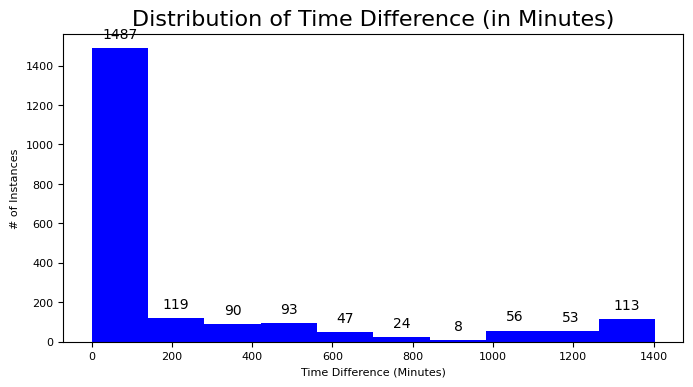

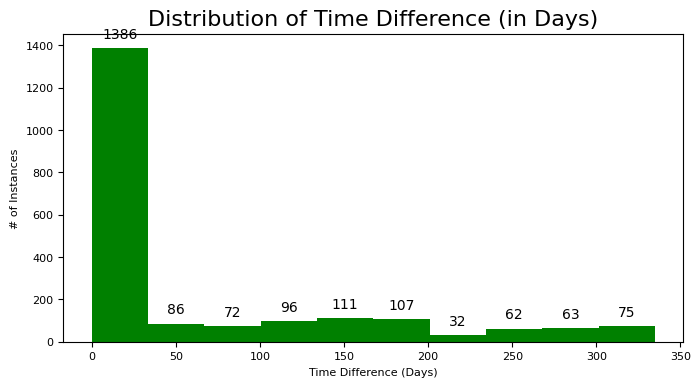

In [17]:
#Understand the amount of time it takes in betweeen purchases (days and minutes)

# Function to create and display histograms with annotations
def plot_histogram_with_annotations(data, column, title, x_label, color):
    plt.figure(figsize=(8, 4))
    counts, bins, _ = plt.hist(data[column], density=False, color=color)
    plt.title(title, size=16)
    plt.xticks(ha='center', size=8)
    plt.yticks(size=8)
    plt.xlabel(x_label, size=8)
    plt.ylabel('# of Instances', size=8)
    
    # Add annotations
    for count, x in zip(counts, bins[:-1]):
        plt.annotate(str(int(count)), xy=(x + (bins[1] - bins[0]) / 2, count),
                     xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

    plt.show()

# Calculate average time difference in days and minutes
cust['min_time'] = cust.groupby('User_id')['DateTime'].transform(min)
cust['max_time'] = cust.groupby('User_id')['DateTime'].transform(max)
cust['avg_time_diff_days'] = (cust['max_time'] - cust['min_time']).dt.days
cust['Avg_time_diff_minutes'] = (cust['max_time'] - cust['min_time']).dt.seconds / 60

# Plot Time Difference (Minutes) histogram with annotations
plot_histogram_with_annotations(cust, 'Avg_time_diff_minutes',
    'Distribution of Time Difference (in Minutes)',
    'Time Difference (Minutes)', 'b')

# Plot Time Difference (Days) histogram with annotations
plot_histogram_with_annotations(cust, 'avg_time_diff_days',
    'Distribution of Time Difference (in Days)',
    'Time Difference (Days)', 'g')





# of repeat purchasers: 32


count     32.00000
mean     101.03125
std       76.81628
min        0.00000
25%       35.25000
50%       90.50000
75%      177.25000
max      245.00000
Name: difference, dtype: float64

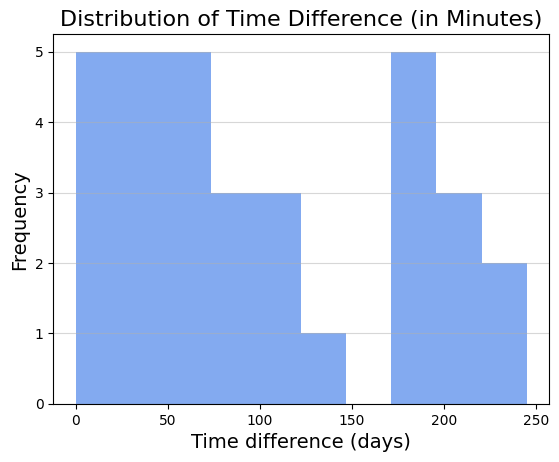

,User_id,DateTime,difference
0,5.144816e+10,"[2019-06-11 13:23:00, 2019-12-12 19:22:00]",184.0
1,5.146260e+10,"[2019-10-20 17:30:00, 2019-12-15 19:03:00]",56.0
2,5.146362e+10,"[2019-10-14 21:44:00, 2019-11-12 21:27:00]",28.0
3,5.146553e+10,"[2019-12-05 19:30:00, 2019-12-12 21:15:00]",7.0
4,5.148038e+10,"[2019-04-09 17:24:00, 2019-10-24 21:18:00]",198.0


In [118]:
#Analysis of finding the average time between repeat purchases

temp = cust.copy()
temp = pd.merge(temp, buyer_dist, on = 'User_id', how = 'left')
temp['no_of_purchases'] = temp['no_of_purchases'].fillna(0)

temp = temp[temp['no_of_purchases'] > 1].reset_index(drop = True) #only look at repeat buyers
print('# of repeat purchasers: ' + str(temp.User_id.nunique()))

def purchase_time_diff(x):
    if len(x) == 2: 
        return (x[1] - x[0]).days
    
    if len(x) == 3:
        diff_12 = abs(x[1]- x[0]).days
        diff_23 = abs(x[2]- x[1]).days
        return (diff_12+diff_23)/2

test = temp[temp['Action'] == 'purchase'].sort_values(by = ['User_id', 'DateTime'])
test = test.groupby('User_id').agg({'DateTime': lambda x: list(x)})
test['difference'] =  test['DateTime'].apply(purchase_time_diff)
test = test.reset_index()

display(test['difference'].describe())

plt.hist(test['difference'], density=False, color='cornflowerblue', alpha=0.8)

plt.title('Distribution of Time Difference (in Minutes)', size=16)
plt.xlabel('Time difference (days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add grid
plt.grid(axis='y', alpha=0.5)

plt.show()
test.head()

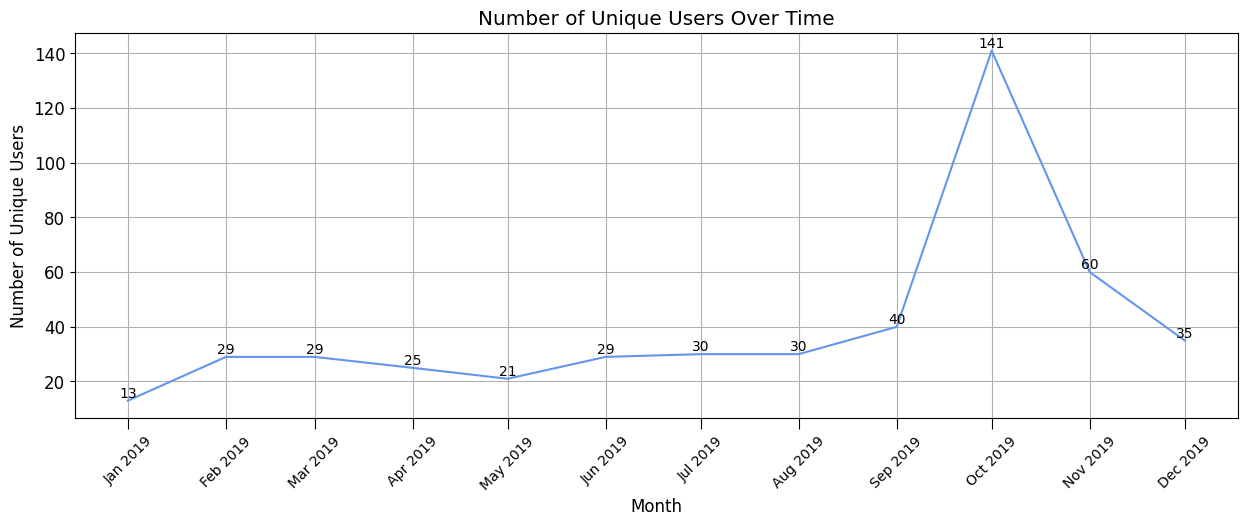

In [149]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make a copy of the DataFrame
temp = cust.copy()

# Extract the month and year from the DateTime column
temp['Date'] = temp['DateTime'].dt.to_period('M').dt.to_timestamp() # converts Date into month
temp = temp.groupby('Date').agg({'User_id': 'nunique'}).reset_index().sort_values(by='Date')

# Set the Date column as the index and plot the data
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(temp['Date'], temp['User_id'], color='cornflowerblue')

# Format the x-axis to show each month as "Jan 2019" and rotate the labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45, size=8)


for x, y in zip(temp['Date'], temp['User_id']):
    ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10
    )
# Add a title and axis labels
plt.title('Number of Unique Users Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Unique Users')

# Increase the font size
plt.rcParams.update({'font.size': 12})

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

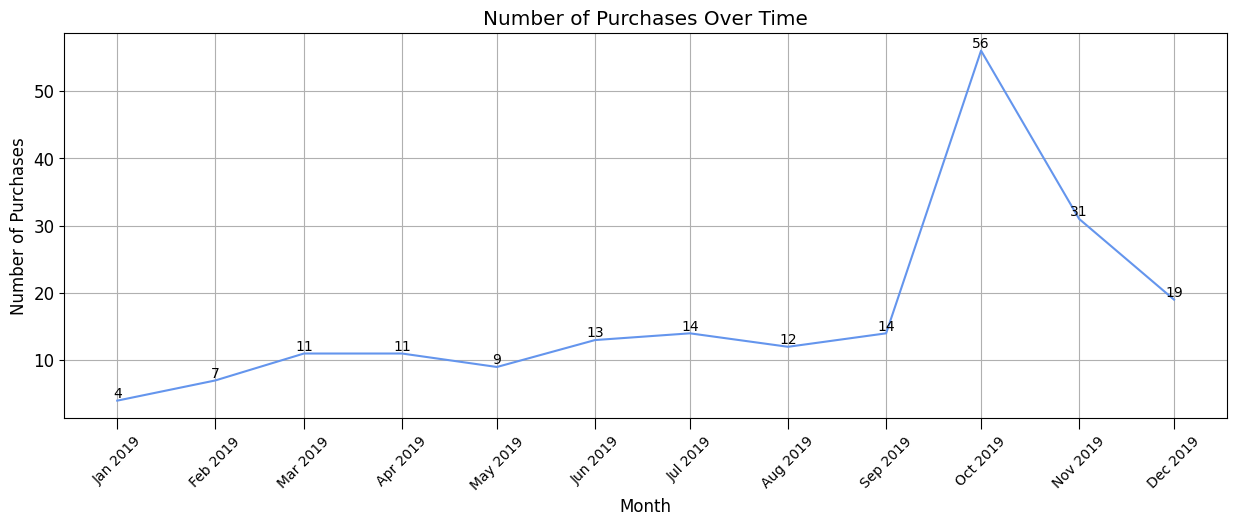

In [186]:
#Distribution of purchase across dates

temp = cust.copy()
temp['Date'] = temp['DateTime'].dt.date
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Month'] = temp['DateTime'].dt.to_period('M').dt.to_timestamp()
temp['DayOfWeek'] = temp['DateTime'].dt.dayofweek

temp = temp[temp['Action'] == 'purchase'].groupby('Month').agg({'Action': 'count'}).reset_index().sort_values(by ='Month')

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(temp['Month'], temp['Action'], color='cornflowerblue')

# Format the x-axis to show each month as "Jan 2019" and rotate the labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', which='major', labelsize=10, rotation=45, size=8)


for x, y in zip(temp['Month'], temp['Action']):
    ax.text(x, y, str(y), ha='center', va='bottom', fontsize=10
    )
# Add a title and axis labels
plt.title('Number of Purchases Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')

# Increase the font size
plt.rcParams.update({'font.size': 12})

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()


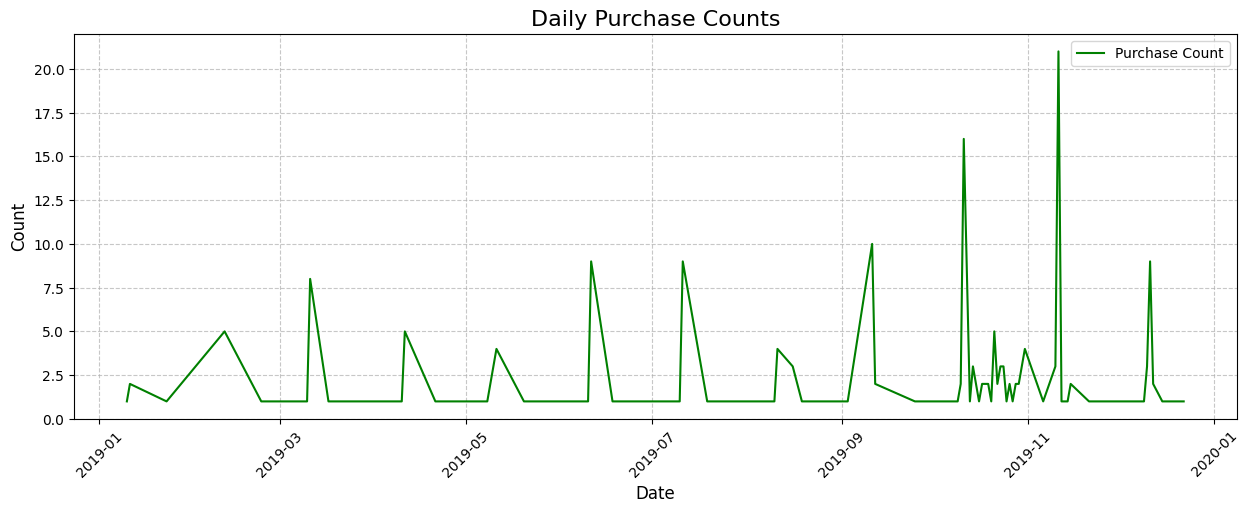

In [21]:
# Distribution of purchases across dates

# Create a temporary DataFrame for data processing
temp = cust.copy()
temp['Date'] = temp['DateTime'].dt.date
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Month'] = temp['DateTime'].dt.month
temp['DayOfWeek'] = temp['DateTime'].dt.dayofweek

# Filter for purchase actions and group by date to count purchases per day
daily_purchase_counts = temp[temp['Action'] == 'purchase'].groupby('Date')['Action'].count().reset_index().sort_values(by='Date')

# Plot daily purchase counts
plt.figure(figsize=(15, 5))
plt.plot(daily_purchase_counts['Date'], daily_purchase_counts['Action'], color='g', label='Purchase Count')
plt.title('Daily Purchase Counts', size=16)
plt.xlabel('Date', size=12)
plt.ylabel('Count', size=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, size=10)
plt.yticks(size=10)
plt.legend()
plt.show()





In [27]:
cust.to_csv("C:/Users/Omar Hamzic/Documents/Project_1_Customer_Propensity_Model/data/data/final_customer_data_cleaned.csv", index =False)#unecessary in this case, but good to help clean out any necessary data points